# Downloading and Extracting Files from Kaggle

In [1]:
! pip install -q kaggle

/bin/bash: /home/chaitanyapeshin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
! pwd
! ls

/bin/bash: /home/chaitanyapeshin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/chaitanyapeshin/Desktop/projects/segmentation_for_color_change
/bin/bash: /home/chaitanyapeshin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
29bb3ece3180_11.jpg  model.ipynb  README.md
assets		     raw_data	  sample_submission.csv


In [3]:
# uncomment if data needs to be downloaded and fed into the appropriate directory through kaggle
# # make sure you have kaggle.json in your home directory (eg. in home/chaitanyapeshin)
# ! mkdir .kaggle
# ! cp ./kaggle.json ./.kaggle/
# ! chmod 600 ./.kaggle/kaggle.json

In [4]:
# uncomment if started console in the home directory
# %cd  Desktop/projects
# ! mkdir 02_segmentation_for_color_change
# %cd 02_segmentation_for_color_change

In [5]:
# uncomment if data needs to be downloaded and fed into the appropriate directory through kaggle
# ! kaggle competitions download -c carvana-image-masking-challenge

# ! mkdir carvana-image-masking-challenge-data
# ! unzip carvana-image-masking-challenge.zip -d carvana-image-masking-challenge-data

# %cd carvana-image-masking-challenge-data/
# ! find . -name "*.zip" -exec unzip {} \;
# ! rm *.zip

# %cd ..
# ! rm *.zip

# %cd carvana-image-masking-challenge-data/
# ! mkdir raw_data
# ! cp -r ./train ./train_hq ./test ./test_hq ./train_masks ./metadata.csv ./train_masks.csv ./raw_data
# ! rm -r ./train ./train_hq ./test ./test_hq ./train_masks ./metadata.csv ./train_masks.csv

# %cd ..

# Importing Packages

In [6]:
import os
import time
import h5py
import math
import pickle
import numpy as np
import pandas as pd
import cv2
import threading
import queue
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc, ndimage
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend as KTF
import tensorflow as tf
from tensorflow.python.client import device_lib

%matplotlib inline

2023-09-10 20:49:16.689887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 20:49:17.464761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import tensorflow as tf

# Configure GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-09-10 20:49:18.116575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 20:49:18.139537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 20:49:18.139949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Reading Data

In [8]:
DATA_PATH = './'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train_small_3')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks_jpg_small_3')
# TRAIN_MASKS_FIXED_PATH = os.path.join(DATA_PATH, 'fixed_masks/fix-HCK')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks_small_3.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

In [9]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

train_masks_df.shape (636, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [10]:
! pwd
! ls

/bin/bash: /home/chaitanyapeshin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/chaitanyapeshin/Desktop/projects/segmentation_for_color_change
/bin/bash: /home/chaitanyapeshin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
29bb3ece3180_11.jpg  model.ipynb  README.md
assets		     raw_data	  sample_submission.csv


In [11]:
# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

HEIGHT = 1024
WIDTH = 1024
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

def get_img_id(img_path):
    img_id = img_path[:15]
    return img_id

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))

def load_image_disk(img_id, folder=TRAIN_PATH):
    img = cv2.imread(os.path.join(folder, img_id + ".jpg"))
    return img

def get_image(img_id):
    return train_imgs[img_id]

# Return mask as 1/0 binary img with single channel
def load_mask_disk(img_id, folder=TRAIN_MASKS_PATH, filetype='jpg'):
    mask_path = os.path.join(folder, "{}_mask.{}".format(img_id, filetype))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"Warning: Failed to read mask image for {img_id}")
        return None

    if np.any(mask > 128):
        # print("1")
        mask[mask > 128] = 1
    # else:
        # print("0")

    mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
    return mask

def get_mask(img_id):
    return train_masks[img_id]

# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = cv2.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

def plot_mask(img_id, folder=TRAIN_MASKS_PATH, filetype='jpg', ax=None):
    mask = cv2.imread(os.path.join(folder, "{}_mask.{}".format(img_id, filetype)))
    if ax == None:
        imgplot = plt.imshow(mask)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(mask)
        ax.axis('off')

def plot_masked_image(img_id, ax=None):
    img = cv2.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = cv2.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.jpg"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1
    masked_img = img * mask
    if ax == None:
        imgplot = plt.imshow(masked_img)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(masked_img)
        ax.axis('off')

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

def resize_img(img, new_s = new_shape):
    return transform.resize(img, new_s)

In [12]:
# Read training images into memory
train_imgs = {}
for img_path in tqdm(os.listdir(TRAIN_PATH)):
    img_id = get_img_id(img_path)
    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))

100%|█████████████████████████████████████████| 636/636 [00:09<00:00, 68.46it/s]


In [13]:
# Read training masks into memory
train_masks = {}
for img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):
    img_id = get_img_id(img_path)
    train_masks[img_id] = np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)

100%|████████████████████████████████████████| 636/636 [00:02<00:00, 299.00it/s]


In [14]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT_101, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=2)

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

# Train/Val Split

In [15]:
import numpy as np
import keras.backend as K

def generate_training_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            x, y = randomShiftScaleRotate(x, y,
                                          shift_limit=(-0.0625, 0.0625),
                                          scale_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
#             x = randomHueSaturationValue(x,
#                                hue_shift_limit=(-50, 50),
#                                sat_shift_limit=(-5, 5),
#                                val_shift_limit=(-15, 15))
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_data_seq(data):
    idx = 0
    while True:
        img_id = data[idx]
        X = get_image(img_id)
        Y = get_mask(img_id)
        yield img_id, X, Y
        idx  += 1
        if idx >= len(data):
            break

# def get_model_memory_usage(batch_size, model):
#     from keras import backend as K

#     shapes_mem_count = 0
#     for l in model.layers:
#         single_layer_mem = 1
#         for s in l.output_shape:
#             if s is None:
#                 continue
#             single_layer_mem *= s
#         shapes_mem_count += single_layer_mem

#     trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
#     non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

#     total_memory = 4*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
#     gbytes = round(total_memory / (1024 ** 3), 3)
#     mbytes = round(total_memory / (1024 ** 2), 3)

#     print('trainable_count', trainable_count, 'non_trainable_count', non_trainable_count, 'gbytes', gbytes, 'mbytes', mbytes)

def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for layer in model.layers:
        if isinstance(layer.output_shape, list):
            for output_shape in layer.output_shape:
                single_layer_mem = 1
                for s in output_shape:
                    if s is None:
                        continue
                    single_layer_mem *= s
                shapes_mem_count += single_layer_mem
        else:
            single_layer_mem = 1
            for s in layer.output_shape:
                if s is None:
                    continue
                single_layer_mem *= s
            shapes_mem_count += single_layer_mem

    # trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    trainable_count = int(np.sum([K.count_params(p) for p in model.trainable_weights]))
    # non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in model.non_trainable_weights]))

    total_memory = shapes_mem_count * batch_size * 4  # Assuming float32 data type
    total_memory += (trainable_count + non_trainable_count) * 4  # Assuming float32 data type

    return total_memory

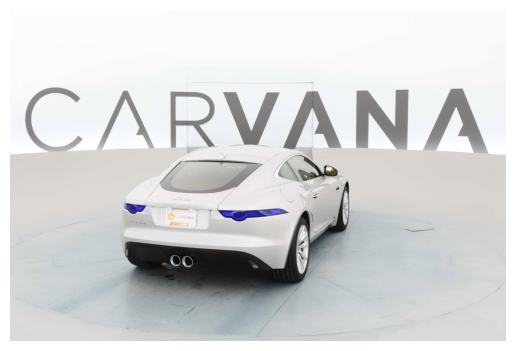

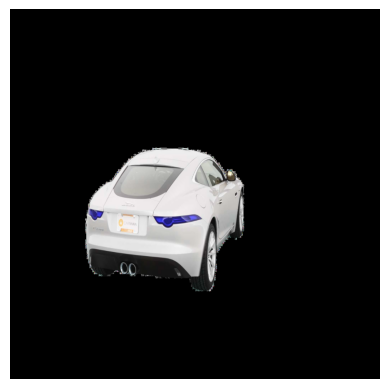

In [16]:
# Visualize impact of random shift scale rotate
random_idx = np.random.randint(len(train_imgs.keys()))
random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = get_image(random_img_id)
mask = get_mask(random_img_id)
temp_img, temp_mask = randomShiftScaleRotate(temp_img, mask,
                              shift_limit=(-0.0625, 0.0625),
                              scale_limit=(-0.1, 0.1),
                              rotate_limit=(-0, 0))

plt.imshow(temp_img * gray2rgb(temp_mask))
plt.axis('off')
plt.show()

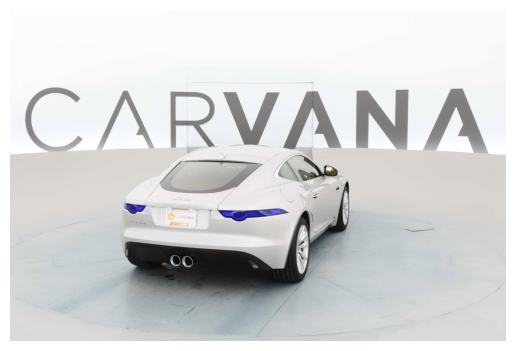

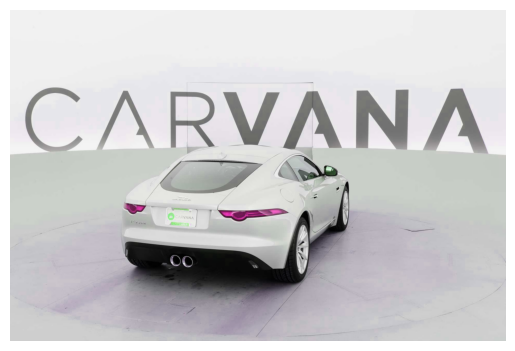

In [17]:
# Visualize impact of random hue saturation
# random_idx = np.random.randint(len(train_imgs.keys()))
# random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = cv2.imread(os.path.join(TRAIN_PATH, '{}.jpg'.format(random_img_id)))
temp_img = randomHueSaturationValue(temp_img,
                               hue_shift_limit=(-50, 50),
                               sat_shift_limit=(-5, 5),
                               val_shift_limit=(-15, 15))
plt.imshow(temp_img)
plt.axis('off')
plt.show()

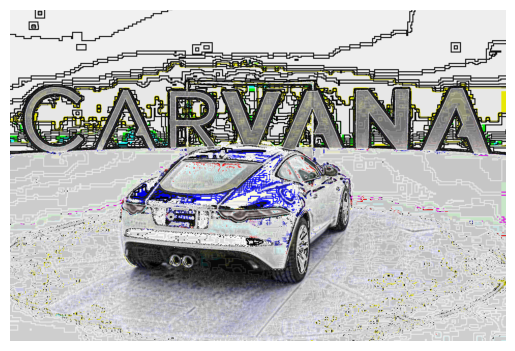

In [18]:
def sharpen(img):
    #face = misc.face(gray=True).astype(float)
    blurred_f = ndimage.gaussian_filter(img, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    alpha = 30
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    return sharpened


plt.imshow(sharpen(temp_img))
plt.axis('off')
plt.show()

# Building Model Architecture

In [19]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

In [20]:
def get_unet_1024(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=1):
    inputs = Input(shape=input_shape)

    with tf.device('/gpu:0'):
        #down0b, down0b_res = down(8, inputs)
        down0a, down0a_res = down(24, inputs)
        down0, down0_res = down(64, down0a)
        down1, down1_res = down(128, down0)
        down2, down2_res = down(256, down1)
        down3, down3_res = down(512, down2)
        down4, down4_res = down(768, down3)

        center = Conv2D(768, (3, 3), padding='same')(down4)
        center = BatchNormalization(epsilon=1e-4)(center)
        center = Activation('relu')(center)

    # with tf.device('/gpu:1'):
        center = Conv2D(768, (3, 3), padding='same')(center)
        center = BatchNormalization(epsilon=1e-4)(center)
        center = Activation('relu')(center)

        up4 = up(768, center, down4_res)
        up3 = up(512, up4, down3_res)
        up2 = up(256, up3, down2_res)
        up1 = up(128, up2, down1_res)
        up0 = up(64, up1, down0_res)
        up0a = up(24, up0, down0a_res)
        #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [22]:
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_coef(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score

def weighted_dice_loss(y_true, y_pred, weight):
    return 1. - weighted_dice_coef(y_true, y_pred, weight)

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.01), 'float32') * K.cast(K.less(averaged_mask, 0.99), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + weighted_dice_loss(y_true, y_pred, weight)
    return loss

# Training Model

In [23]:
BATCH_SIZE = 1

In [24]:
# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 4
steps_per_epoch = int(len(img_ids) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'min',
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = get_unet_1024()
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
get_model_memory_usage(BATCH_SIZE, model)

2023-09-10 20:49:31.809097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 20:49:31.809537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 20:49:31.809844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   672         ['input_1[0][0]']                
                                24)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1024,   96         ['conv2d[0][0]']                 
 alization)                     24)                                                           

/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5031076580

In [25]:
# # Re-training old model
# ts = str(int(time.time()))
# model_name = 'malhot'
# num_epochs = 300
# steps_per_epoch = 101
# run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
#                                                                           BATCH_SIZE,
#                                                                           num_epochs,
#                                                                           steps_per_epoch,
#                                                                           ts)
# tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
# checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

# modelCheckpoint = ModelCheckpoint(checkpoint_loc,
#                                   monitor = 'val_loss',
#                                   save_best_only = True,
#                                   mode = 'min',
#                                   verbose = 1,
#                                   save_weights_only = True)

# tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

# callbacks_list = [modelCheckpoint, tensorboard]

# model = get_unet_1024()
# model.load_weights(os.path.join(MODELS_PATH, 'model-1506108708-weights.h5'))
# model.compile(loss=weighted_bce_dice_loss, optimizer=AdamAccumulate(lr=1e-5, accum_iters=5), metrics=[dice_coef])
# model.summary()

In [26]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)
VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)

In [27]:
print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

model_path = os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts))
history_path = os.path.join(MODELS_PATH, 'model-{}.history'.format(ts))
model.save(model_path)
pickle.dump(history.history, open(history_path, "wb"))
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

Starting run model=malhot-batch_size=1-num_epoch=4-steps_per_epoch=508-ts=1694359171
Epoch 1/4


/tmp/ipykernel_57200/132024285.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-09-10 20:49:33.156227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:49:35.943642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-10 20:49:36.464055: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-10 20:49:36.464765: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-10 20:49:36.464792: W tensorflow/compiler/xla/stream_ex

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_31/Conv2D' defined at (most recent call last):
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_57200/132024285.py", line 2, in <module>
      history = model.fit_generator(
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2636, in fit_generator
      return self.fit(
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/chaitanyapeshin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d_31/Conv2D'
OOM when allocating tensor with shape[24,24,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_31/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8425]

In [ ]:
# clear all gpu memory (due to an error in the previous train run)
# doesn't work on sessions on google colab hosted using a local runtime through jupyter
# unfortunately seems to be useless in this case for me :(

import tensorflow as tf
import matplotlib.pyplot as plt

# Close plots and figures
plt.close('all')

# # Delete variables if needed
# del variable_name

# Clear GPU memory
def clear_gpu_memory():
    tf.keras.backend.clear_session()

# Call the function to free GPU memory
clear_gpu_memory()


import gc
gc.collect()

In [ ]:
# installing package to clear up GPU memory when running on local
!pip install numba

In [ ]:
# to clear up GPU memory when running on local
# unfortunately, this kills the kernel and also, is useless :(
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
model = get_unet_1024()
model.load_weights(os.path.join(MODELS_PATH, 'model-1506223599-weights.h5'))
model.compile(loss=bce_dice_loss, optimizer=Adam(1e-5), metrics=[dice_coef])

In [ ]:
model = load_model(os.path.join(MODELS_PATH, 'model-1506223599.h5'), custom_objects={'weighted_bce_dice_loss': weighted_bce_dice_loss,
                                                                                    'dice_coef': dice_coef})

In [ ]:
model.evaluate_generator(valid_generator, VALIDATION_STEPS)

# Error Analysis on Val Set

In [ ]:
validation_dices = []
for img_id, X, Y in generate_validation_data_seq(validation_ids):
    error = model.evaluate(np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0), verbose=0)
    validation_dices.append((img_id, error[0], error[1]))

val_eval_df = pd.DataFrame.from_records(validation_dices, columns=['img_id', 'val_loss', 'dice_coef'])
val_eval_df.head()